In [60]:
import os
import tensorflow as tf
import io
import numpy as np
import tensorflow_addons as tfh

In [61]:
#Define variables

batch_size = 32
img_height = 256
img_width = 256
img_channels = 3

In [62]:
#Normalize pixel function

@tf.autograph.experimental.do_not_convert
def _normalize_img(img, label):
    image = tf.cast(img/255. ,tf.float32)
    return image, label

In [63]:
#Update Data Directory Name

data_dir = 'data_folder/all_data_processed' #Change this to lfw & pubfig dataset

In [207]:
#Load Dataset

lfw_pubfig_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

lfw_pubfig_ds_norm = lfw_pubfig_ds.map(_normalize_img)

Found 20804 files belonging to 1751 classes.


In [65]:
#Set Dataset Split 0.7/0.15/0.15

train_split = 0.7
val_split = 0.15
test_split = 0.15

In [66]:
#Split Dataset

ds_size = len(list(lfw_pubfig_ds_norm))
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)
test_size = int(test_split * ds_size)

train_ds = lfw_pubfig_ds_norm.take(train_size)    
val_ds = lfw_pubfig_ds_norm.skip(train_size).take(val_size)
test_ds = lfw_pubfig_ds_norm.skip(train_size + val_size).take(test_size)

In [67]:
#Print Dataset Sizes

print(len(list(train_ds)) * batch_size, train_ds.element_spec) # Default Batches of 32
print(len(list(val_ds)) * batch_size, val_ds.element_spec) # Default Batches of 32
print(len(list(test_ds)) * batch_size, test_ds.element_spec) # Default Batches of 32

14560 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
3104 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
3104 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [68]:
#Create the Baseline Model Class

class BaselineModel(tf.keras.Model):
    def __init__(self):
        super(BaselineModel, self).__init__()
        
        self.input_layer = tf.keras.layers.Input((img_height, img_width, img_channels))
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same', activation='relu')
        self.mpool1 = tf.keras.layers.MaxPooling2D(pool_size=2)
        
        self.flat1 = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation=None)

        self.output_layer = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.mpool1(x)
        x = self.flat1(x)
        x = self.fc1(x)
        out = self.output_layer(x)
        
        return out
    
    def model(self):
        return tf.keras.Model(inputs=self.input_layer, outputs=self.call(self.input_layer))
        

In [ ]:
#Create the Advanced Model Class (Insert Model Architecture)

class AdvancedModel(tf.keras.Model):
    def __init__(self):
        super(AdvancedModel, self).__init__()
        
        self.input_layer = tf.keras.layers.Input((img_height, img_width, img_channels))
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, padding='same', activation='relu')
        self.mpool1 = tf.keras.layers.MaxPooling2D(pool_size=2)
        
        self.flat1 = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation=None)

        self.output_layer = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.mpool1(x)
        x = self.flat1(x)
        x = self.fc1(x)
        out = self.output_layer(x)
        
        return out
    
    def model(self):
        return tf.keras.Model(inputs=self.input_layer, outputs=self.call(self.input_layer))

In [69]:
#Get Model

#Uncomment for Baseline Model
model_name = 'baseline'
model = BaselineModel()

#Uncomment for Advanced Model
#model_name = 'advanced'
#model = AdvancedModel()

model.model().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      9472      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_4 (Dense)             (None, 128)               134217856 
                                                                 
 lambda_4 (Lambda)           (None, 128)               0         
                                                           

In [70]:
#Compliel Model with Adam Optimizer and Triplet Loss

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tfa.losses.TripletHardLoss())

In [71]:
#Train Model
EPOCHS = 50

history = model.fit(
        x=train_ds,
        epochs=EPOCHS,
        validation_data=val_ds)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
455/455 [==============================] - ETA: 0s - loss: 0.2871WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001BB354C2840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
455/455 [==============================] - 1124s 2s/step - loss: 0.2871 - val_loss: 0.2241
Epoch 2/50
455/455 [==============================] - 1009s 2s/step - loss: 0.1826 - val_loss: 0.1908
Epoch 3/50
455/455 [==============================] - 1002s 2s/step - loss: 0.1680 - val_loss: 0.1689
Epoch 4/50
455/455 [==============================] - 996s 2s/step - loss: 0.1586 - val_loss: 0.1844
Epoch 5/50
455/455 [==============================] - 995s 2s/step - loss: 0.1554 - val_loss: 0.1644
Epoch 6/50
455/455 [==============================] - 995s 2s/step - loss: 0.1534 - val_loss: 0.1554
Epoch 7/50
455/455 [==============================] - 993s 2s/step - loss: 0.1490 - val_los

KeyboardInterrupt: 

In [72]:
#Save Model
model.save('saved_model/' + model_name + '_model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: saved_model/baseline_model\assets


INFO:tensorflow:Assets written to: saved_model/baseline_model\assets


In [73]:
#Save training data
import pandas as pd

# convert the history.history dict to a pandas DataFrame:   
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'saved_model/' + model_name + '_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [74]:
#Constuct a database of known image encodings from the training/verification dataset as a reference to evaluate the test dataset

pubfig_db_dict = {}
for images, labels in train_ds.take(len(list(train_ds))):
    for i in range(labels.shape[0]):
        if int(labels[i]) not in pubfig_db_dict:
            pubfig_db_dict[int(labels[i])] = model.predict(np.expand_dims(images[i], axis=0))
            
for images, labels in val_ds.take(len(list(val_ds))):
    for i in range(labels.shape[0]):
        if int(labels[i]) not in pubfig_db_dict:
            pubfig_db_dict[int(labels[i])] = model.predict(np.expand_dims(images[i], axis=0))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 109ms/step


In [224]:
#Create lists from reference dict
label_list = np.squeeze(np.array(list(pubfig_db_dict.keys())))
ref_list = np.squeeze(np.array(list(pubfig_db_dict.values())))
print(ref_list.shape)

(1730, 128)


In [222]:
#Make Model Predictions (vectorized by batch)
test_num = 0
test_correct = 0

threshold = 1.3
test_samples = len(list(test_ds))

for images, labels in test_ds.take(test_samples):
    #predict batch
    batch_pred = model.predict(images)
    
    #Calculate norm differerecen for each embedding and all references
    norm_diffs = np.zeros((ref_list.shape[0], batch_pred.shape[0]))
    for i, ref in enumerate(ref_list):
        norm_diffs[i] = np.linalg.norm(batch_pred - ref, axis=1)
    norm_diffs = norm_diffs.transpose()
    
    #Get the min labels and test labels
    min_labels = np.argmin(norm_diffs, axis=1)
    
    test_num += len(min_labels)
    for i in range(len(min_labels)):
        min_index = min_labels[i]
        test_label = labels[i]
        label = label_list[min_index]
    
        if norm_diffs[i][min_index] < threshold:
            if label == test_label:
                test_correct += 1
        elif test_label not in pubfig_db_dict:
            test_correct += 1

1/1 [==============================] - 1s 745ms/step


In [223]:
#Print Facial Recognition Accuracy and Average Distance from correct class
print(test_correct/test_num)

0.05025773195876289
0.0


<AxesSubplot:title={'center':'Baseline Model Training'}, xlabel='Epochs', ylabel='Triplet Loss'>

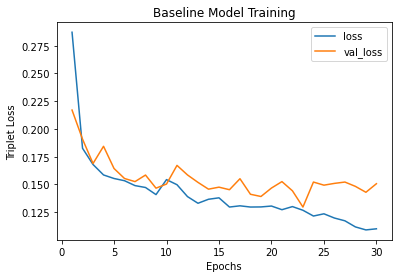

In [81]:
#Load training Loss Data
import pandas as pd

trained_df = pd.read_csv(hist_csv_file)

trained_df.plot(x=0, y=[1,2], kind='line', title='Baseline Model Training', xlabel='Epochs', ylabel='Triplet Loss')